# Analyzing frequency and power spectrum of significant cells.
* using raw fluorescence data 
* 11/12/2023 fixing a bug when filtering significant and non significant cells

In [1]:
import sys
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("/home/gergely/code/sleep/base/")

from suite2p_class import Suite2p
from eeg_class import eegData
from behavior_class import behaviorData
import neuropil as nl

In [2]:
sima_folders = [
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima",
    "/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima",
]

In [3]:
results = {}

for sima_folder in sima_folders[1:]:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    cells = s2p_data.cells()
    npil = s2p_data.npil()

    nrem_cells = cells[:, df["NREM"].values]
    awake_immobile_cells = cells[:, df["awake_immobile"].values]

    significant_cells = nl.statistics.significance_calc(
        nrem_cells, awake_immobile_cells
    )
    # creating mask for significant cell
    mask = np.zeros(cells.shape[0], dtype=bool)

    mask[significant_cells] = True

    significant_cell_data = cells[mask, :]
    nonsignificant_cell_data = cells[~mask, :]

    mean_significant = np.mean(significant_cell_data, axis=0)
    mean_nonsignificant = np.mean(nonsignificant_cell_data, axis=0)

    nrem_sig_mean = pd.Series(mean_significant[df["NREM"].values])
    awake_sig_mean = pd.Series(mean_significant[df["awake_immobile"].values])
    nrem_nonsig_mean = pd.Series(mean_nonsignificant[df["NREM"].values])
    awake_nonsig_mean = pd.Series(mean_nonsignificant[df["awake_immobile"].values])

    nrem_sig_freq, nrem_sig_psd = nl.freq_calc(nrem_sig_mean, resolution=0.01)
    awake_sig_freq, awake_sig_psd = nl.freq_calc(awake_sig_mean, resolution=0.01)
    nrem_nonsig_freq, nrem_nonsig_psd = nl.freq_calc(nrem_nonsig_mean, resolution=0.01)
    awake_nonsig_freq, awake_nonsig_psd = nl.freq_calc(
        awake_nonsig_mean, resolution=0.01
    )

    sima_dict["awake_sig"] = {
        "freq": awake_sig_freq,
        "psd": awake_sig_psd,
    }

    sima_dict["nrem_sig"] = {
        "freq": nrem_sig_freq,
        "psd": nrem_sig_psd,
    }

    sima_dict["awake_nonsig"] = {
        "freq": awake_nonsig_freq,
        "psd": awake_nonsig_psd,
    }

    sima_dict["nrem_nonsig"] = {
        "freq": nrem_nonsig_freq,
        "psd": nrem_nonsig_psd,
    }

    results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima
/data2/gergely/invivo_DATA/sleep/sert54a_5/4_

In [4]:
results_df = pd.DataFrame.from_dict(results)
results_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
awake_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."


In [5]:
# 1. Extract PSD arrays
psd_df = results_df.applymap(
    lambda d: d["psd"] if isinstance(d, dict) and "psd" in d else np.nan
)
psd_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"[3033.9768, 8963.222, 7880.561, 4621.9946, 239...","[6060.9844, 22374.871, 27613.656, 22000.521, 1...","[7034.0913, 40284.152, 50131.227, 28614.389, 1...","[1772.0178, 7472.82, 7150.942, 5453.891, 4314....","[3882.711, 18796.926, 33444.656, 38747.164, 23...","[9413.007, 37634.54, 34300.953, 15469.587, 141...","[34099.33, 101710.26, 91502.44, 31259.732, 101...","[6069.3813, 20592.229, 20623.395, 18871.04, 85...","[17720.322, 78363.0, 63287.574, 32878.094, 206..."
nrem_sig,"[1598.6028, 6596.7144, 7832.703, 5696.2246, 51...","[3400.2603, 15841.115, 17261.076, 12829.068, 7...","[11713.126, 59205.848, 60918.617, 40915.45, 38...","[970.4773, 4899.7305, 5730.2974, 3710.344, 272...","[5978.059, 20670.895, 19944.725, 16285.548, 14...","[10988.671, 44055.86, 67613.74, 76763.68, 5853...","[12874.072, 67142.12, 70003.875, 36928.79, 197...","[11495.693, 53135.63, 47209.82, 22267.076, 149...","[2941.9636, 13638.778, 18988.775, 16200.243, 1..."
awake_nonsig,"[4988.86, 17607.676, 16701.592, 9361.137, 4856...","[5202.889, 20343.744, 17180.912, 11800.31, 877...","[22657.7, 94678.3, 149383.31, 193872.16, 15604...","[8292.209, 23032.932, 14509.612, 6969.6772, 56...","[18477.469, 67241.445, 54429.574, 34669.797, 3...","[21913.893, 88647.72, 101369.164, 84175.89, 58...","[9146.032, 20158.625, 14777.214, 11456.033, 46...","[945.2339, 3122.6938, 2718.7915, 1552.3236, 17...","[59812.18, 233584.72, 222592.05, 80195.04, 411..."
nrem_nonsig,"[1998.4028, 6934.0474, 6095.4624, 4370.8257, 4...","[2000.6782, 8169.3013, 8329.189, 5052.2495, 32...","[10098.395, 35695.285, 38962.816, 33586.426, 3...","[378.67453, 3719.177, 5102.4463, 4962.103, 363...","[2973.024, 14524.74, 13465.866, 8824.986, 7123...","[5612.0728, 22846.104, 43181.754, 51770.574, 4...","[3083.3613, 17349.002, 21530.38, 15101.111, 95...","[1192.491, 3996.95, 3451.6484, 1842.649, 1051....","[2734.4941, 11128.889, 13238.208, 7872.9966, 3..."


<Axes: title={'center': 'Non-significant cells'}, xlabel='Frequency (Hz)', ylabel='Power/Frequency (dB/Hz)'>

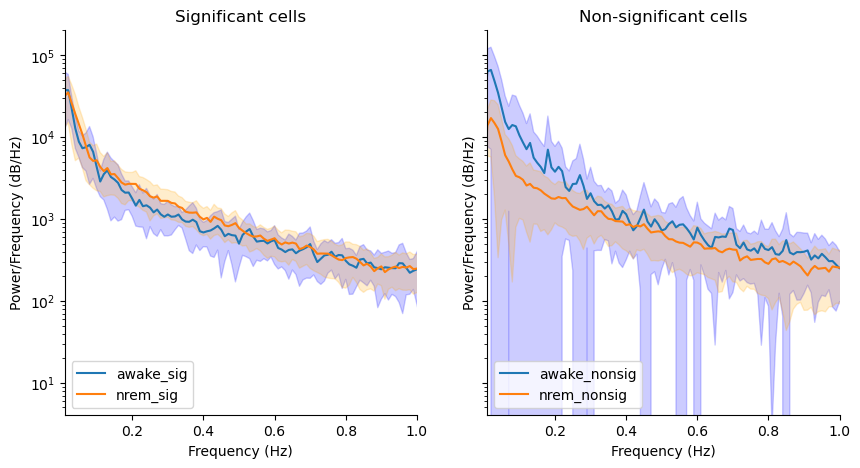

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

nl.spectral_density_plot(
    psd_df, ["awake_sig", "nrem_sig"], ax=ax[0], labels={"title": "Significant cells"}
)
nl.spectral_density_plot(
    psd_df,
    ["awake_nonsig", "nrem_nonsig"],
    ax=ax[1],
    labels={"title": "Non-significant cells"},
)

## Neuropil signal

In [7]:
npil_results = {}

for sima_folder in sima_folders[1:]:
    print(sima_folder)
    sima_dict = {}

    # Load eeg data
    file_name = join(sima_folder, "eeg", "velo_eeg.csv")
    eeg_velo = eegData.load_processed_velocity_eeg(file_name=file_name)
    eeg_velo["mobile_immobile"] = behaviorData.define_immobility(
        eeg_velo["filtered velo"]
    )
    df = eegData.brain_state_filter(
        velo_eeg_df=eeg_velo,
        states=["awake_mobile", "awake_immobile", "NREM", "REM", "other"],
    )

    s2p_folder = join(sima_folder, "suite2p")
    s2p_data = Suite2p(s2p_folder=s2p_folder)
    cells = s2p_data.cells()
    npil = s2p_data.npil()

    nrem_cells = cells[:, df["NREM"].values]
    awake_immobile_cells = cells[:, df["awake_immobile"].values]

    significant_cells = nl.statistics.significance_calc(
        nrem_cells, awake_immobile_cells
    )

    mask = np.zeros(npil.shape[0], dtype=bool)

    mask[significant_cells] = True

    significant_npil = npil[mask, :]
    nonsignificant_npil = npil[~mask, :]

    mean_significant = np.mean(significant_npil, axis=0)
    mean_nonsignificant = np.mean(nonsignificant_npil, axis=0)

    nrem_sig_mean = pd.Series(mean_significant[df["NREM"].values])
    awake_sig_mean = pd.Series(mean_significant[df["awake_immobile"].values])
    nrem_nonsig_mean = pd.Series(mean_nonsignificant[df["NREM"].values])
    awake_nonsig_mean = pd.Series(mean_nonsignificant[df["awake_immobile"].values])

    nrem_sig_freq, nrem_sig_psd = nl.freq_calc(nrem_sig_mean, resolution=0.01)
    awake_sig_freq, awake_sig_psd = nl.freq_calc(awake_sig_mean, resolution=0.01)
    nrem_nonsig_freq, nrem_nonsig_psd = nl.freq_calc(nrem_nonsig_mean, resolution=0.01)
    awake_nonsig_freq, awake_nonsig_psd = nl.freq_calc(
        awake_nonsig_mean, resolution=0.01
    )

    sima_dict["awake_sig"] = {
        "freq": awake_sig_freq,
        "psd": awake_sig_psd,
    }

    sima_dict["nrem_sig"] = {
        "freq": nrem_sig_freq,
        "psd": nrem_sig_psd,
    }

    sima_dict["awake_nonsig"] = {
        "freq": awake_nonsig_freq,
        "psd": awake_nonsig_psd,
    }

    sima_dict["nrem_nonsig"] = {
        "freq": nrem_nonsig_freq,
        "psd": nrem_nonsig_psd,
    }

    npil_results[sima_folder] = sima_dict

/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima


/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima
/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima
/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima
/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323

In [8]:
npil_results_df = pd.DataFrame.from_dict(npil_results)
npil_results_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_sig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
awake_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."
nrem_nonsig,"{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0...","{'freq': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0..."


In [9]:
# 1. Extract PSD arrays
npil_psd_df = npil_results_df.applymap(
    lambda d: d["psd"] if isinstance(d, dict) and "psd" in d else np.nan
)
npil_psd_df

,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima,/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima,/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima
awake_sig,"[1441.5817, 5126.0977, 4568.6187, 2477.085, 11...","[452.19977, 2005.0394, 2210.786, 1266.7781, 83...","[819.01337, 9335.476, 16358.6045, 9679.538, 42...","[750.4217, 2759.779, 2492.85, 1968.2709, 1860....","[533.7478, 2520.1875, 2599.2544, 2995.62, 1193...","[1530.1859, 6540.6836, 6549.2085, 3311.8376, 2...","[14213.326, 38360.02, 29062.834, 12287.573, 38...","[344.44867, 1086.9227, 987.9343, 568.5753, 480...","[10853.789, 48100.55, 41710.46, 17989.395, 144..."
nrem_sig,"[971.51666, 3567.7476, 4001.6655, 3224.0027, 2...","[255.59404, 1105.4291, 1545.9939, 1248.233, 93...","[2399.014, 15192.33, 18302.56, 13685.732, 1408...","[532.46716, 2561.7034, 2598.1304, 1409.0582, 9...","[709.9486, 2458.246, 2166.8052, 1774.8917, 161...","[2460.3416, 9609.3545, 17011.463, 21702.408, 1...","[3772.1707, 21033.697, 23392.352, 13559.547, 7...","[325.84915, 1013.5902, 1003.1657, 761.0861, 34...","[581.343, 4282.752, 7838.468, 7918.4976, 5472...."
awake_nonsig,"[1870.9696, 6561.2515, 5426.5034, 3007.5254, 1...","[705.85803, 2810.6697, 2638.81, 1588.0801, 870...","[748.53796, 9979.089, 16658.627, 8636.216, 474...","[629.01715, 2423.9512, 2101.074, 1781.4901, 17...","[445.44495, 2885.3867, 2965.7607, 2259.9775, 1...","[2979.869, 11631.113, 11365.0205, 6336.9146, 4...","[13533.578, 35470.02, 25055.824, 10447.369, 32...","[413.73813, 1388.6151, 1175.728, 659.714, 799....","[10721.646, 48344.258, 43820.156, 18641.006, 1..."
nrem_nonsig,"[945.8204, 3439.7327, 3722.592, 2800.7593, 253...","[301.87646, 1253.0308, 1489.5896, 986.2563, 83...","[2337.695, 15724.241, 19573.305, 14306.321, 14...","[309.06564, 1753.555, 1889.0878, 948.04663, 70...","[492.8944, 1718.2274, 1522.9032, 1511.996, 132...","[3587.496, 13679.012, 23280.938, 28845.88, 229...","[3077.7368, 17149.47, 19295.18, 11254.493, 668...","[485.58707, 1503.2678, 1599.7345, 1144.1316, 4...","[439.3506, 3205.6606, 6286.768, 6524.0547, 437..."


<Axes: title={'center': "Non-significant cells' npil"}, xlabel='Frequency (Hz)', ylabel='Power/Frequency (dB/Hz)'>

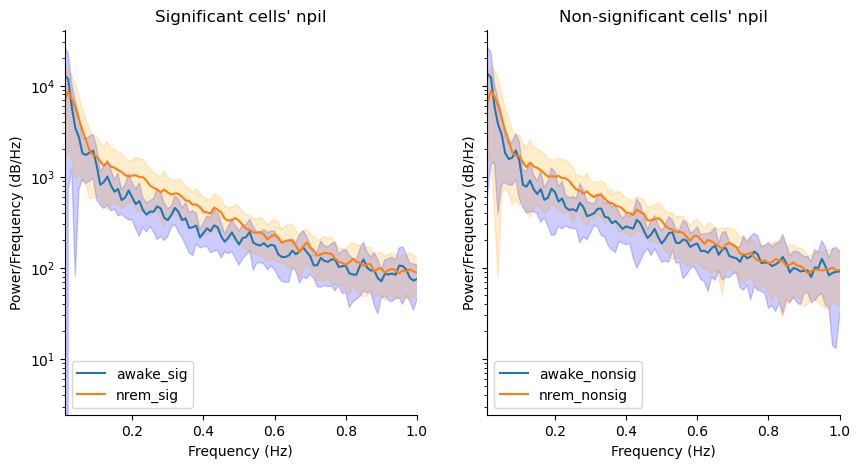

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

nl.spectral_density_plot(
    npil_psd_df,
    ["awake_sig", "nrem_sig"],
    ax=ax[0],
    labels={"title": "Significant cells' npil"},
)
nl.spectral_density_plot(
    npil_psd_df,
    ["awake_nonsig", "nrem_nonsig"],
    ax=ax[1],
    labels={"title": "Non-significant cells' npil"},
)